# Sentiment Analysis

The data is from https://www.kaggle.com/ritresearch/happydb

In [1]:
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv("data/cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed afte...,My grandmother start to walk from the bed afte...,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and w...,I picked my daughter up from the airport and w...,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [3]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "sentence", "ground_truth_category": "ground_truth"}
)
sample_df.head()

,wid,reflection_period,original_hm,sentence,modified,num_sentence,ground_truth,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed afte...,My grandmother start to walk from the bed afte...,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and w...,I picked my daughter up from the airport and w...,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [4]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["sentence"], train_df["ground_truth"]
X_test, y_test = test_df["sentence"], test_df["ground_truth"]

In [5]:
train_df["ground_truth"].value_counts(normalize=True)

affection           0.342571
achievement         0.300799
bonding             0.127238
enjoy_the_moment    0.105694
leisure             0.090927
nature              0.018307
exercise            0.014463
Name: ground_truth, dtype: float64

There is a class imbalance issue, with a limited number of examples for the "nature" and "exercise" categories. These examples are spread across seven different categories. The most prevalent category, "affection," accounts for only 34% of the examples. Consequently, the scores for the Dummy model are expected to be low.

In [6]:
models = {
    "dummy": DummyClassifier(random_state=123), 
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, multi_class="ovr", random_state=123),
}

In [7]:
def mean_std_cross_val_scores(estimator, features, target, **kwargs):
    
    cv_scores = cross_validate(estimator, features, target, **kwargs)

    mean_scores = pd.DataFrame(cv_scores).mean()
    std_scores = pd.DataFrame(cv_scores).std()
    formatted_scores = []

    for i in range(len(mean_scores)):
        formatted_scores.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=formatted_scores, index=mean_scores.index)

In [8]:

results_dict = {}
for model_name, model in models.items():
    pipe = make_pipeline(CountVectorizer(), model)
    results_dict[model_name] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True)

results_df = pd.DataFrame(results_dict).T


In [9]:
results_df

,fit_time,score_time,test_score,train_score
dummy,0.059 (+/- 0.002),0.014 (+/- 0.001),0.343 (+/- 0.000),0.343 (+/- 0.000)
Decision Tree,0.351 (+/- 0.008),0.015 (+/- 0.001),0.734 (+/- 0.011),0.998 (+/- 0.000)
KNN,0.065 (+/- 0.003),0.380 (+/- 0.019),0.663 (+/- 0.006),0.767 (+/- 0.002)
RBF SVM,5.879 (+/- 0.105),1.061 (+/- 0.026),0.788 (+/- 0.004),0.900 (+/- 0.002)
Naive Bayes,0.071 (+/- 0.003),0.014 (+/- 0.001),0.764 (+/- 0.011),0.850 (+/- 0.002)
Logistic Regression,0.610 (+/- 0.079),0.014 (+/- 0.000),0.830 (+/- 0.009),0.952 (+/- 0.002)


In [10]:
pipe_lr = make_pipeline(
    CountVectorizer(), LogisticRegression(max_iter=2000, multi_class="ovr")
)
pipe_lr.fit(X_train, y_train)
vocab = pipe_lr.named_steps["countvectorizer"].get_feature_names_out()

In [11]:
from scipy.stats import lognorm, loguniform, randint

param_grid = {
    "logisticregression__C": loguniform(1e-3, 1e3),
    "countvectorizer__max_features": randint(100, len(vocab)),
}

In [12]:
random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train);

print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "param_countvectorizer__max_features",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameter values:  {'countvectorizer__max_features': 6584, 'logisticregression__C': 1.5463515822289584}
Best score: 0.831


rank_test_score,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
mean_train_score,0.962982,0.940351,0.955067,0.950946,0.940376,0.947835,0.926747,0.934409,0.975473,0.982578,...,0.759356,0.752503,0.736017,0.706079,0.708405,0.658162,0.631511,0.581648,0.557424,0.542682
mean_test_score,0.830888,0.830382,0.83018,0.83018,0.830079,0.829977,0.828663,0.828258,0.82755,0.826134,...,0.739052,0.734905,0.720037,0.697482,0.694954,0.649034,0.62476,0.577223,0.554364,0.540609
param_logisticregression__C,1.546352,1.154872,1.198861,0.963502,0.768407,0.884532,0.728258,0.610391,3.278078,4.757372,...,0.020429,0.018784,0.014633,0.011278,0.009133,0.004504,0.00357,0.002218,0.001472,0.001059
param_countvectorizer__max_features,6584,2809,6302,8050,6357,7863,2963,7850,5574,6678,...,4097,2687,1322,362,2002,6187,4071,5584,2724,4284
mean_fit_time,1.274605,1.147488,1.397664,1.395694,1.078842,1.203666,1.02451,1.21836,2.557746,2.329527,...,0.572951,0.844475,0.557724,0.458715,0.50106,0.388182,0.306294,0.449368,0.26299,0.367433


In [24]:
best_estimator = random_search.best_estimator_

vocab = best_estimator["countvectorizer"].get_feature_names_out()  

weights = best_estimator["logisticregression"].coef_  


pd.DataFrame(weights, index=best_estimator.classes_, columns = vocab)

,00,000,00am,10,100,1000,100th,102,10class,10th,...,yrs,yucky,yummy,zealand,zelda,zero,zoey,zombies,zoo,zootopia
achievement,0.379360,0.303398,0.002874,-0.028916,1.234930,0.487230,-3.402656e-05,0.151720,-0.074544,0.043730,...,6.347968e-01,-0.024069,-0.377102,-0.152038,0.018742,-0.821678,-0.127047,-0.275702,-0.000073,-0.139730
affection,-0.106577,-0.299403,0.000045,0.347792,-1.245095,-0.013139,1.330528e-03,-0.152831,-0.004539,-0.068570,...,-8.545614e-01,0.152109,-0.215388,0.128478,-0.085145,-0.013061,0.399661,-0.006306,-0.496020,-0.029593
bonding,-0.206686,-0.037661,-0.003726,-0.237552,-0.055085,-0.065723,-1.223074e-02,-0.038913,0.036378,-0.174477,...,-7.412790e-06,-0.020742,-0.078409,-0.001442,-0.080572,-0.021579,-0.003731,-0.319732,-0.064920,-0.050036
enjoy_the_moment,-0.424760,0.037510,-0.063343,-0.106894,-0.306540,-0.479096,-1.435309e-04,-0.073053,-0.000153,-0.107681,...,-7.321452e-05,-0.019195,0.619303,-0.000245,0.313917,0.169050,-0.023297,-0.040663,-0.150669,-0.257636
exercise,-0.063478,-0.014978,-0.000194,-0.125665,0.123022,-0.067867,-3.626549e-07,-0.029656,-0.000002,-0.008372,...,-4.503065e-07,-0.000496,-0.040822,-0.000359,-0.043436,-0.002585,-0.000049,-0.003715,-0.031295,-0.020891
leisure,-0.242436,-0.083604,-0.007482,-0.250807,-0.474644,-0.129912,-1.565118e-06,-0.008580,-0.000004,-0.034355,...,-7.394601e-07,-0.000209,0.264438,-0.007501,-0.461464,0.850159,-0.000659,0.715230,0.252651,0.616976
nature,-0.135100,-0.025190,-0.000653,-0.221703,-0.166705,-0.033672,-6.332329e-04,-0.003120,-0.000328,-0.037773,...,-2.722580e-07,-0.003293,-0.047589,-0.000045,-0.058553,-0.022348,-0.000222,-0.001844,0.820815,-0.168609


In [49]:
random_search.classes_

array(['achievement', 'affection', 'bonding', 'enjoy_the_moment',
       'exercise', 'leisure', 'nature'], dtype=object)

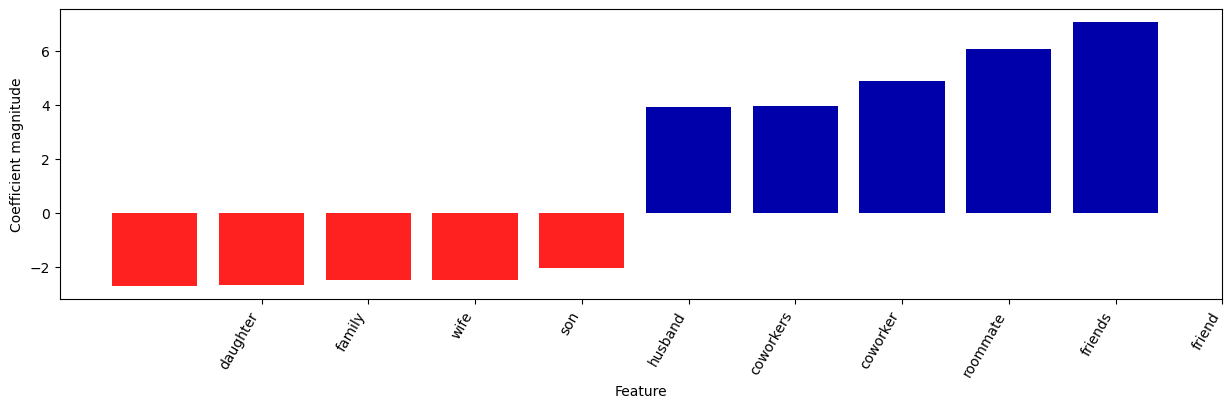

In [52]:

bonding_coeff_df = pd.DataFrame(weights[2], index=vocab, columns=["Coefficient"])

sorted_bonding_coeff = bonding_coeff_df.sort_values(by="Coefficient", ascending=False)

import mglearn
mglearn.tools.visualize_coefficients(weights[2], vocab, n_top_features=5)

In [55]:
sorted_bonding_coeff 

,Coefficient
friend,7.036907
friends,6.047156
roommate,4.871043
coworker,3.938303
coworkers,3.915521
...,...
husband,-2.035118
son,-2.464574
wife,-2.465450
family,-2.651356


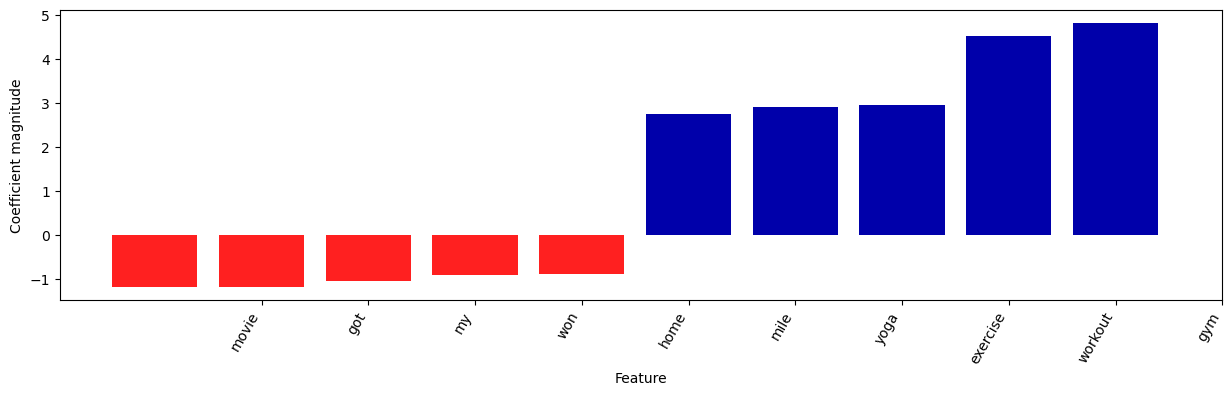

In [56]:
exercise_coeff_df = pd.DataFrame(weights[4], index=vocab, columns=["Coefficient"])
sorted_exercise_coeff = exercise_coeff_df.sort_values(by="Coefficient", ascending=False)

import mglearn
mglearn.tools.visualize_coefficients(weights[4], vocab, n_top_features=5)

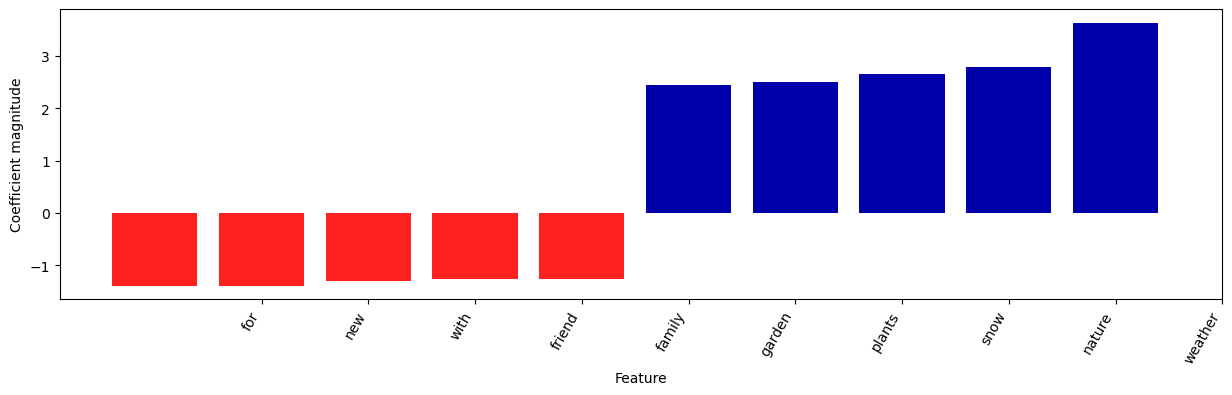

In [58]:
nature_coeff_df = pd.DataFrame(weights[6], index=vocab, columns=["Coefficient"])
sorted_nature_coeff = exercise_coeff_df.sort_values(by="Coefficient", ascending=False)

import mglearn
mglearn.tools.visualize_coefficients(weights[6], vocab, n_top_features=5)

In [59]:
sorted_nature_coeff 

,Coefficient
gym,4.818794
workout,4.526269
exercise,2.953804
yoga,2.906876
mile,2.764611
...,...
home,-0.894093
won,-0.910559
my,-1.046380
got,-1.177914


In [29]:
random_search_best_score = random_search.best_score_
train_score = random_search.score(X_train, y_train)
test_score = random_search.score(X_test, y_test)


print("Random Search best model score: %0.3f" % random_search_best_score)
print(
    "Train score on the full train set: %0.3f" % train_score
)
print("Test score on the full test set: %0.3f" % test_score)

Random Search best model score: 0.831
Train score on the full train set: 0.957
Test score on the full test set: 0.824


### Verify the results

In [30]:
random_search.classes_

array(['achievement', 'affection', 'bonding', 'enjoy_the_moment',
       'exercise', 'leisure', 'nature'], dtype=object)

In [44]:
bonding_prob = np.max(random_search.predict_proba(X_test)[:, 2])
bonding_index = np.argmax(random_search.predict_proba(X_test)[:, 2])
bonding_msg = X_test.iloc[affection_index]

print(
    "Moment with highest probability (%0.3f) of being an affection is:\n%s"
    % (affection_prob, affection_msg)
)

Moment with highest probability (1.000) of being an affection is:
After about a month, I sadly had to fly back to my home in Sydney. I said my sorrowful good byes to Sudi and suddenly had a thought. I turned my head and said aYou have been a great friend to me, so I think you should also be a great friend to Ziggya I gave Ziggy to Sudi so he had a friend to play with while I was gone. He was so excited and I felt so pleased with myself. Now every year we fly back to the island and see Ziggy and Sudi, and now Sudi, Ziggy and I are best friends forever- BFF.



In [45]:
exercise_prob = np.max(random_search.predict_proba(X_test)[:, 4])
exercise_index = np.argmax(random_search.predict_proba(X_test)[:, 4])
exercise_msg = X_test.iloc[exercise_index]

print(
    "Moment with highest probability (%0.3f) of being an exercise is:\n%s"
    % (exercise_prob, exercise_msg)
)

Moment with highest probability (0.961) of being an exercise is:
I had a good workout at my gym


In [46]:
nature_prob = np.max(random_search.predict_proba(X_test)[:, 6])
nature_index = np.argmax(random_search.predict_proba(X_test)[:, 6])
nature_msg = X_test.iloc[nature_index]

print(
    "Moment with highest probability (%0.3f) of being an nature is:\n%s"
    % (nature_prob, nature_msg)
)

Moment with highest probability (0.941) of being an nature is:
lucky to live in the country in New York on acres of land. A highlight of my trip was taking Ferg out for a hike in the woods with my cousin. I watched him sniff every possible thing in sight, while continuing to check in and make sure we were still with him.


In [47]:
test_moments = [
    "I adopted a cute puppy from the shelter.",
    "I completed a challenging puzzle in record time.",
    "I planted a garden in my backyard and saw the first sprouts.",
    "I made a new friend at the gym during my workout.",
    "I attended an inspiring lecture on personal development.",
    "I treated myself to a relaxing spa day."
]

In [48]:
predictions = random_search.predict(test_moments)

df = pd.DataFrame(
    {"Review": test_moments, "predictions": predictions}
) 
df

,Review,predictions
0,I adopted a cute puppy from the shelter.,affection
1,I completed a challenging puzzle in record time.,achievement
2,I planted a garden in my backyard and saw the ...,nature
3,I made a new friend at the gym during my workout.,exercise
4,I attended an inspiring lecture on personal de...,achievement
5,I treated myself to a relaxing spa day.,enjoy_the_moment
